In [1]:
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import umap
from scipy import stats
from sklearn.decomposition import PCA
import joblib

# Making analysis datasets

In [2]:
pwd

'/wynton/protected/home/sirota/ykatsuhara/AD_PCA_Clustering/NoOutlier_AD_DiagnosisName'

In [3]:
# Get Alzheimer's Disease diagnosis information
alzcohort = pd.read_csv('/wynton/protected/home/sirota/ykatsuhara/AD_PCA_Clustering/ad_demographics.csv')
alzdiag = pd.read_csv('/wynton/protected/home/sirota/ykatsuhara/AD_PCA_Clustering/ad_diagnosis.csv')



## Change clounmns'name

In [4]:
alzcohort = alzcohort.rename(columns={'PatientDurableKey':'PatientID','estimated_age':'Age', 'FirstRace':'Race','Status':'Death_Status','Value':'ICD10'})
alzdiag = alzdiag.rename(columns={'PatientDurableKey':'PatientID','estimated_age':'Age', 'FirstRace':'Race','Status':'Death_Status','Value':'ICD10'})


In [5]:
alzdiag['PatientID'].nunique()

8804

## Exclude the record with NaN for ICD10

In [6]:
alzdiag = alzdiag[alzdiag['ICD10'].notna()]


In [7]:
alzdiag['PatientID'].nunique()

8804

## Make a pivot table

In [8]:
n = 'DiagnosisName'
alzdiag_pivot = pd.pivot_table(alzdiag[[n, 'PatientID']].drop_duplicates(), 
         values = [n], index = 'PatientID', columns = [n],
         aggfunc = lambda x: 1 if len(x)>0 else 0, fill_value = 0)
alzdiag_pivot['isAD'] = 1

In [9]:
alzdiag_pivot

DiagnosisName,"""walking corpse"" syndrome",'light-for-dates' infant with signs of fetal malnutrition,(HFpEF) heart failure with preserved ejection fraction (HCC),(Idiopathic) normal pressure hydrocephalus (HCC),1st MTP arthritis,1st degree AV block,"2-part displaced fracture of surgical neck of right humerus, initial encounter for closed fracture","2-part displaced fracture of surgical neck of right humerus, subsequent encounter for fracture with routine healing","2-part nondisplaced fracture of surgical neck of left humerus, initial encounter for closed fracture","2-part nondisplaced fracture of surgical neck of left humerus, subsequent encounter for fracture with routine healing",...,"Zoster ocular disease, unspecified",Zoster ophthalmicus,Zoster with other complications,Zoster without complications,"Zygoma fracture, closed, initial encounter","Zygomatic arch fracture, closed, initial encounter","Zygomatic fracture, closed, initial encounter","Zygomatic fracture, right side, subsequent encounter for fracture with routine healing","Zygomatic fracture, unspecified side, initial encounter for closed fracture (HCC)",isAD
PatientID,,,,,,,,,,,,,,,,,,,,,
D0003B2687D8F9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
D000D5B83D9620,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
D000D6884BD199,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
D0016F824B7B74,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
D00195531E21B1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DFFCD874260A78,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
DFFE6A5DC77E11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
DFFF132A593DAB,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [10]:
alldiag_pivot = alzdiag_pivot

### Delete columns containing "Alzheimer" in the disease name

In [11]:
colstodrop = alldiag_pivot.columns[alldiag_pivot.columns.str.contains('alzheimer', flags=re.IGNORECASE)]

In [12]:
alldiag_pivot = alldiag_pivot.drop(colstodrop , axis=1)

In [13]:
alldiag_pivot

DiagnosisName,"""walking corpse"" syndrome",'light-for-dates' infant with signs of fetal malnutrition,(HFpEF) heart failure with preserved ejection fraction (HCC),(Idiopathic) normal pressure hydrocephalus (HCC),1st MTP arthritis,1st degree AV block,"2-part displaced fracture of surgical neck of right humerus, initial encounter for closed fracture","2-part displaced fracture of surgical neck of right humerus, subsequent encounter for fracture with routine healing","2-part nondisplaced fracture of surgical neck of left humerus, initial encounter for closed fracture","2-part nondisplaced fracture of surgical neck of left humerus, subsequent encounter for fracture with routine healing",...,"Zoster ocular disease, unspecified",Zoster ophthalmicus,Zoster with other complications,Zoster without complications,"Zygoma fracture, closed, initial encounter","Zygomatic arch fracture, closed, initial encounter","Zygomatic fracture, closed, initial encounter","Zygomatic fracture, right side, subsequent encounter for fracture with routine healing","Zygomatic fracture, unspecified side, initial encounter for closed fracture (HCC)",isAD
PatientID,,,,,,,,,,,,,,,,,,,,,
D0003B2687D8F9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
D000D5B83D9620,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
D000D6884BD199,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
D0016F824B7B74,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
D00195531E21B1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DFFCD874260A78,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
DFFE6A5DC77E11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
DFFF132A593DAB,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### Calculate total number of non-AD complications

In [14]:
alldiag_pivot['#diagnosis'] = alldiag_pivot.loc[:, ~alldiag_pivot.columns.isin(['isAD'])].sum(axis=1)

<AxesSubplot:xlabel='#diagnosis', ylabel='Count'>

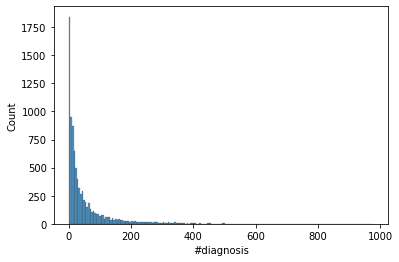

In [15]:
sns.histplot(alldiag_pivot, x= alldiag_pivot['#diagnosis'])

In [16]:
alldiag_pivot['#diagnosis'].describe()

count    8804.000000
mean       50.902204
std        77.387373
min         0.000000
25%         7.000000
50%        21.000000
75%        60.000000
max       978.000000
Name: #diagnosis, dtype: float64

## Filter case who have at least one diagnosis name in addition to AD

In [17]:
alldiag_pivot

DiagnosisName,"""walking corpse"" syndrome",'light-for-dates' infant with signs of fetal malnutrition,(HFpEF) heart failure with preserved ejection fraction (HCC),(Idiopathic) normal pressure hydrocephalus (HCC),1st MTP arthritis,1st degree AV block,"2-part displaced fracture of surgical neck of right humerus, initial encounter for closed fracture","2-part displaced fracture of surgical neck of right humerus, subsequent encounter for fracture with routine healing","2-part nondisplaced fracture of surgical neck of left humerus, initial encounter for closed fracture","2-part nondisplaced fracture of surgical neck of left humerus, subsequent encounter for fracture with routine healing",...,Zoster ophthalmicus,Zoster with other complications,Zoster without complications,"Zygoma fracture, closed, initial encounter","Zygomatic arch fracture, closed, initial encounter","Zygomatic fracture, closed, initial encounter","Zygomatic fracture, right side, subsequent encounter for fracture with routine healing","Zygomatic fracture, unspecified side, initial encounter for closed fracture (HCC)",isAD,#diagnosis
PatientID,,,,,,,,,,,,,,,,,,,,,
D0003B2687D8F9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,7
D000D5B83D9620,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,21
D000D6884BD199,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,21
D0016F824B7B74,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,85
D00195531E21B1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DFFCD874260A78,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,106
DFFE6A5DC77E11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,10
DFFF132A593DAB,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,27


In [18]:
alldiag_pivot = alldiag_pivot[alldiag_pivot['#diagnosis'] >= 1]

In [19]:
alldiag_pivot

DiagnosisName,"""walking corpse"" syndrome",'light-for-dates' infant with signs of fetal malnutrition,(HFpEF) heart failure with preserved ejection fraction (HCC),(Idiopathic) normal pressure hydrocephalus (HCC),1st MTP arthritis,1st degree AV block,"2-part displaced fracture of surgical neck of right humerus, initial encounter for closed fracture","2-part displaced fracture of surgical neck of right humerus, subsequent encounter for fracture with routine healing","2-part nondisplaced fracture of surgical neck of left humerus, initial encounter for closed fracture","2-part nondisplaced fracture of surgical neck of left humerus, subsequent encounter for fracture with routine healing",...,Zoster ophthalmicus,Zoster with other complications,Zoster without complications,"Zygoma fracture, closed, initial encounter","Zygomatic arch fracture, closed, initial encounter","Zygomatic fracture, closed, initial encounter","Zygomatic fracture, right side, subsequent encounter for fracture with routine healing","Zygomatic fracture, unspecified side, initial encounter for closed fracture (HCC)",isAD,#diagnosis
PatientID,,,,,,,,,,,,,,,,,,,,,
D0003B2687D8F9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,7
D000D5B83D9620,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,21
D000D6884BD199,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,21
D0016F824B7B74,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,85
D00195531E21B1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DFFCD874260A78,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,106
DFFE6A5DC77E11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,10
DFFF132A593DAB,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,27


In [20]:
alldiag_pivot['#diagnosis'].describe()

count    8363.000000
mean       53.586392
std        78.490722
min         1.000000
25%         9.000000
50%        23.000000
75%        63.000000
max       978.000000
Name: #diagnosis, dtype: float64

### Join background table to Alldiag_pivot

In [21]:
demographic_cols = ['PatientID', 'Age', 'Sex', 'Race', 'Death_Status']

In [26]:
alldiag_pivot = alldiag_pivot.merge((alzcohort[demographic_cols]).set_index('PatientID'),
                how = 'left', left_index = True, right_index = True)
alldiag_pivot = alldiag_pivot.fillna(0)

In [27]:
alldiag_pivot

,"""walking corpse"" syndrome",'light-for-dates' infant with signs of fetal malnutrition,(HFpEF) heart failure with preserved ejection fraction (HCC),(Idiopathic) normal pressure hydrocephalus (HCC),1st MTP arthritis,1st degree AV block,"2-part displaced fracture of surgical neck of right humerus, initial encounter for closed fracture","2-part displaced fracture of surgical neck of right humerus, subsequent encounter for fracture with routine healing","2-part nondisplaced fracture of surgical neck of left humerus, initial encounter for closed fracture","2-part nondisplaced fracture of surgical neck of left humerus, subsequent encounter for fracture with routine healing",...,"Zygomatic arch fracture, closed, initial encounter","Zygomatic fracture, closed, initial encounter","Zygomatic fracture, right side, subsequent encounter for fracture with routine healing","Zygomatic fracture, unspecified side, initial encounter for closed fracture (HCC)",isAD,#diagnosis,Age,Sex,Race,Death_Status
PatientID,,,,,,,,,,,,,,,,,,,,,
D0003B2687D8F9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,7,88,Female,White or Caucasian,Alive
D000D5B83D9620,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,21,91,Female,White or Caucasian,Alive
D000D6884BD199,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,21,90,Male,White or Caucasian,Alive
D0016F824B7B74,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,85,91,Male,White or Caucasian,Deceased
D00195531E21B1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,66,91,Female,Black or African American,Alive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DFFCD874260A78,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,106,91,Female,Native Hawaiian or Other Pacific Islander,Deceased
DFFE6A5DC77E11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,10,74,Male,White or Caucasian,Alive
DFFF132A593DAB,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,27,90,Female,White or Caucasian,Alive


# Dimentional Reduction

## (If necessary) Sampling from the dataset

In [28]:
demographic_cols = ['Age', 'Sex', 'Race', 'Death_Status','#diagnosis']

In [29]:
z = alldiag_pivot[demographic_cols]
X = alldiag_pivot.drop('isAD', axis=1).drop(demographic_cols, axis=1).astype('int32')

In [30]:
X

,"""walking corpse"" syndrome",'light-for-dates' infant with signs of fetal malnutrition,(HFpEF) heart failure with preserved ejection fraction (HCC),(Idiopathic) normal pressure hydrocephalus (HCC),1st MTP arthritis,1st degree AV block,"2-part displaced fracture of surgical neck of right humerus, initial encounter for closed fracture","2-part displaced fracture of surgical neck of right humerus, subsequent encounter for fracture with routine healing","2-part nondisplaced fracture of surgical neck of left humerus, initial encounter for closed fracture","2-part nondisplaced fracture of surgical neck of left humerus, subsequent encounter for fracture with routine healing",...,Zoster ocular disease,"Zoster ocular disease, unspecified",Zoster ophthalmicus,Zoster with other complications,Zoster without complications,"Zygoma fracture, closed, initial encounter","Zygomatic arch fracture, closed, initial encounter","Zygomatic fracture, closed, initial encounter","Zygomatic fracture, right side, subsequent encounter for fracture with routine healing","Zygomatic fracture, unspecified side, initial encounter for closed fracture (HCC)"
PatientID,,,,,,,,,,,,,,,,,,,,,
D0003B2687D8F9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
D000D5B83D9620,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
D000D6884BD199,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
D0016F824B7B74,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
D00195531E21B1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DFFCD874260A78,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DFFE6A5DC77E11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DFFF132A593DAB,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# PCA

In [31]:
pca = PCA(n_components= 2000, random_state=42)

In [32]:
mapper = pca.fit(X)

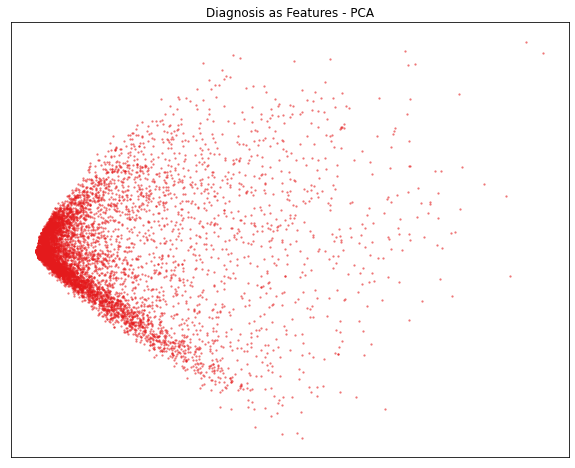

In [33]:
X_embedded = mapper.transform(X)

with sns.color_palette("Set1"):
    fig = plt.figure(figsize=(10,8))
    reordered_indices = np.arange(X_embedded.shape[0])
    np.random.shuffle(reordered_indices)
    sns.scatterplot(x= X_embedded[reordered_indices,0], y= X_embedded[reordered_indices,1],
    s= 5, linewidth= .0, alpha= .6)
    ax= plt.gca()
    ax.set(xticks=[], yticks=[], facecolor='white');
    plt.title('Diagnosis as Features - PCA')

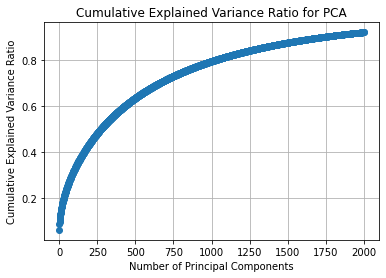

In [34]:
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

plt.plot(cumulative_variance_ratio, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio for PCA')
plt.grid(True)
plt.show()

## 1000 PCA components are included in the analysis dataset

## PCA(n=1500)

In [35]:
pca = PCA(n_components=1000, random_state=42)
data_pca = pca.fit_transform(X)

In [36]:
# Save the model
joblib.dump(pca, 'pca1000_model_rdm42.joblib')

# Save the transformed data
np.save('data_pca1000_rdm42.npy', data_pca)


In [37]:
# Save as Pickle file
alldiag_pivot.to_pickle('pivot_table_rdm42.pkl')

In [38]:
# Save as CSV file
alldiag_pivot.to_csv('pivot_table_rdm42.csv', index=False)